# preliminaries

In [1]:
import numpy as np
from sklearn import datasets
from scipy.stats import norm
from scipy.stats import cauchy
import scipy.stats as stats
from scipy.spatial import distance 
import math
from sklearn.preprocessing import Normalizer
from hashlib import md5
import sys
from sklearn.model_selection import train_test_split
import timeit
import matplotlib.pyplot as plt

mbyte = 1048576
norm_l1 = Normalizer(norm='l1')
norm_l2 = Normalizer(norm='l2')

In [2]:
def R(P):
    max_p = P.max(axis=0)
    min_p = P.min(axis=0)
    R = np.sqrt(np.sum((max_p - min_p) ** 2))
    return R / 2

def generate_md5(H):
    hmd5 = md5()
    hmd5.update(str(H).encode(encoding='utf-8'))
    return hmd5.hexdigest()

# datasets

In [3]:
%store -r nearest_neighbor
%store -r dataset_titles
%store -r train
%store -r test
%store -r K
%store -r test_n

In [4]:
dataset_title = dataset_titles[0]
dataset_title

'SIFT-10K'

## 测试 L1 与 L2 距离结果类似

In [5]:
q = test[dataset_title][0]

In [6]:
np.argsort([distance.minkowski(p, q, p=1) for p in train[dataset_title]])[:20]

array([2176, 2837,  882, 3752,  190, 1045, 3615, 4009,  292, 1272,  107,
        816, 1295, 9541,  492,  146,  224, 1156, 9806, 4938])

In [7]:
np.argsort([distance.euclidean(p, q) for p in train[dataset_title]])[:20]

array([2176, 3752,  882, 4009, 2837,  190, 3615,  816, 1045, 1884,  224,
       3013,  292, 1272, 5307, 4938, 1295,  492, 9211, 3625])

# preprocessing

In [8]:
def get_r1(P):
    """
    Desc:
        Caculate r1
        20 points nearest neighbor
    
    Arg:
        P: dataset
    
    Return:
        r1
    """
    n = P.shape[0]
    idxs = np.random.choice(np.arange(n), 20, replace=False)
    r1 = 0
    far = 0
    for idx in idxs:
        q = P[idx]
        ds = np.sort(np.array([distance.minkowski(q, p, p=1) for p in P]))
        r1 += ds[1]
        far += ds[-1]
    print('nearest: {:.4f}, far: {:.4f}'.format(math.ceil(r1 / len(idxs)), math.ceil(far / len(idxs))))
    return math.ceil(r1 / len(idxs))

$$
p_1 = 1 - \frac{r}{d^{'}} \\
p_2 = 1 - \frac{r(1+\epsilon)}{d^{'}}
$$

In [9]:
def get_Pr(P, Cd, r, epsilon):
    """
    Desc:
        p1, p2
    
    Args:
        P: dataset
        Cd: max value * d
        r: r1
        epsilon: approximate factor
    
    Returns:
        p1
        p2
    """
    
    p1 = 1 - r / Cd
    p2 = 1 - (1 + epsilon) * r / Cd
    return p1, p2

**引用 B**
$$
k = log_{p_2}\frac{B}{n} \\
\rho = \frac{\text{ln} 1/p_1}{\text{ln} 1/p_2} \\
L = (\frac{n}{B})^\rho
$$

**不引用 B**

$$
k = log_{p_2}\frac{1}{n} \\
\rho = \frac{\text{ln} 1/p_1}{\text{ln} 1/p_2} \\
L = n^\rho
$$

**引入错误率 $\delta$**

$$
L \ge \frac{\text{log}1/\delta}{-\text{log}(1-p_1^k)}
$$

In [10]:
def get_kL(P, p1, p2, delta, B=None):
    """
    Desc:
        k, L
    
    Args:
        P
        p1
        p2
        delta: miss ratio
        B: with M
    
    Returns:
        k
        L
    """
    n, d = P.shape
    if B is None:
        k = math.ceil(np.log(1/n) / np.log(p2))
    else:
        k = math.ceil(np.log(n/B) / np.log(1/p2))

    L = math.ceil(-np.log(1 / delta) / np.log(1 - (p1 ** k)))
    return k, L

$$
M = \alpha\frac{n}{B}
$$

In [11]:
def get_M(n, B, alpha):
    return math.ceil(alpha * n / B)

In [12]:
def preprocessing(P, k, L, C, M=None, random_state=None):
    """
    Desc:
        Construct Data Struture.

    Args:
        P: dataset
        k: number of h
        L: number of g
        M: number of hash tables
        C: max value, Cd = C * d
        random_state: random seed

    Returns:
        M is None:
            G
            hash_tables
        Else:
            fp_rand: fingerprint
            G
            hash_tables
    """
    
    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)

    n, d = P.shape
    
    hash_tables = []
    # for M
    if M is not None:
        fp_rand = rand.randint(0, M, k)

    Cd = C * d
    # hash family
    G = np.sort(rand.choice(np.arange(Cd), (L, k), replace=True).astype(np.int))
    
    hash_tables = []
    for i in range(L):
        hash_tables.append(dict())

    for idx, p in enumerate(P):
        Gv = (p[G // C] > (G % C)).astype(np.int)
        if M is not None:
            Gv = Gv.dot(fp_rand) % M
            for i, gv in enumerate(Gv):
                if gv in hash_tables[i]:
                    hash_tables[i][gv].append(idx)
                else:
                    hash_tables[i][gv] = [idx]
    
    if M is None:
        return G, hash_tables
    else:
        return G, hash_tables, fp_rand

# query

In [13]:
def query(args, q):
    """
    Desc:
        Query Function
    
    Args:
        P: dataset
        q: query
        C: max value
        M: number of hash tables
        fp_rand
        G
        hash_tables
    
    Result:
        nearest points (maybe)
    """
    C = args['C']
    G = args['G']
    hash_tables = args['hash_tables']
    
    Gv = (q[G // C] > (G % C)).astype(np.int)
    
    if 'M' in args:
        M = args['M']
        fp_rand = args['fp_rand']
        Gv = Gv.dot(fp_rand) % M
    
    result = []

    for i, gv in enumerate(Gv):
        if gv in hash_tables[i]:
            result.append(hash_tables[i][gv])
    
    if len(result) != 0:
        result = np.unique(np.concatenate(np.array(result)))

    return result

# Metrics

In [14]:
def metrics(P, query_func, args, test, exact_nearest):
    """
    Pr of find nearest neighbor, Error ratio, memory
    
    Args:
        P
        query_func(args, q)
        args
        test
        exact_nearest
    
    Returns:
        pr of find nearest neighbor
        error ratio
        memory
    """
    # memory
    size = 0
    hash_tables = args['hash_tables']
    for buckets in hash_tables:
        for idx, bucket in buckets.items():
            size += sys.getsizeof(idx)
            for b in bucket:
                size += sys.getsizeof(b)
    memory = size / mbyte
    
    test_n = test.shape[0]
    correct = 0
    dis_total = 0

    for i in range(test_n):
        result = query_func(args, test[i])
        if len(result) != 0:
            if exact_nearest[i] in result:
                correct += 1   
        else:
            correct += 1

        dis = np.array([distance.euclidean(P[idx], test[i]) for idx in result])
        idx_approximate_nearest_neighbor = dis.argsort()[0]
        dis_total += ((dis[idx_approximate_nearest_neighbor] / 
                      distance.euclidean(test[i], P[exact_nearest[i]])) - 1)

    return correct / test_n, dis_total / test_n, memory

# test

In [15]:
P = train[dataset_title]
C = P.max()

In [16]:
B = 100
alpha = 2
epsilon = 1
n, d = P.shape
Cd = C * d
M = get_M(n, B, 2)

In [17]:
%%time
r = get_r1(P)

nearest: 1002.0000, far: 5876.0000
CPU times: user 2.81 s, sys: 93.4 ms, total: 2.9 s
Wall time: 2.82 s


In [18]:
p1, p2 = get_Pr(P, Cd, r, epsilon)
print('p1: {:.4f}, p2: {:.4f}'.format(p1, p2))

p1: 0.9565, p2: 0.9130


In [19]:
k, L = get_kL(P, p1, p2, delta=0.3)

print('k = {}, L = {}'.format(k, L))

k = 102, L = 112


In [20]:
print(preprocessing.__doc__)


    Desc:
        Construct Data Struture.

    Args:
        P: dataset
        k: number of h
        L: number of g
        M: number of hash tables
        C: max value, Cd = C * d
        random_state: random seed

    Returns:
        M is None:
            G
            hash_tables
        Else:
            fp_rand: fingerprint
            G
            hash_tables
    


In [21]:
%%time
G, hash_tables, fp_rand = preprocessing(P, k, L, C, M=M, random_state=1)

CPU times: user 3.73 s, sys: 22.2 ms, total: 3.75 s
Wall time: 3.76 s


In [22]:
args = dict()
args['C'] = C
args['G'] = G
args['M'] = M
args['fp_rand'] = fp_rand
args['hash_tables'] = hash_tables

In [23]:
%%time
metrics(P=P, args=args, query_func=query, 
        exact_nearest=nearest_neighbor[dataset_title], test=test[dataset_title])

CPU times: user 5.94 s, sys: 2.49 ms, total: 5.94 s
Wall time: 5.95 s


(0.6, 0.05512110869751192, 30.59039306640625)

## 固定 k，调整 L

In [24]:
k, L = get_kL(P, p1, p2, 0.1)
print('k = {}, L = {}'.format(k, L))

k = 102, L = 214


In [25]:
arr_L = np.arange(50, 650, 50)

In [26]:
%%time

arr_error = []
arr_pr = []

for L in arr_L:
    G, hash_tables, fp_rand = preprocessing(P, k, L, C, M=M, random_state=1)

    args = dict()
    args['C'] = C
    args['G'] = G
    args['M'] = M
    args['hash_tables'] = hash_tables
    args['fp_rand'] = fp_rand

    value_error, value_pr, value_memory = metrics(P=P, args=args, query_func=query, 
            exact_nearest=nearest_neighbor[dataset_title], test=test[dataset_title])
    
    arr_error.append(value_error)
    arr_pr.append(value_pr)

CPU times: user 4min 19s, sys: 129 ms, total: 4min 19s
Wall time: 4min 20s


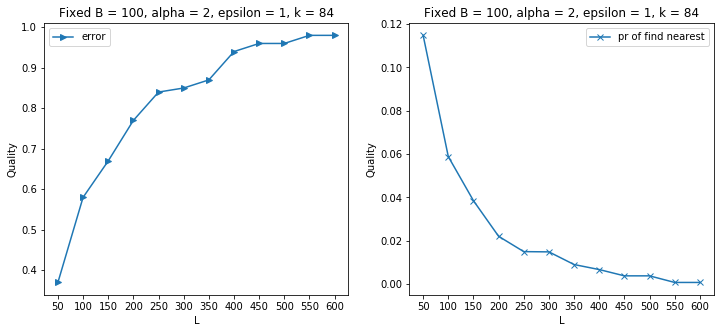

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(arr_L, arr_error, '>-', label='error')
plt.title('Fixed B = 100, alpha = 2, epsilon = 1, k = 84')
plt.xticks(arr_L)
plt.xlabel('L')
plt.ylabel('Quality')
plt.legend()

plt.subplot(122)
plt.plot(arr_L, arr_pr, 'x-', label='pr of find nearest')
plt.xticks(arr_L)
plt.xlabel('L')
plt.ylabel('Quality')
plt.legend()
plt.title('Fixed B = 100, alpha = 2, epsilon = 1, k = 84')
plt.show()